# Predicting Diabetes Prognosis

## Introduction:

Diabetes is a medical condition where the afflicted body is unable to create enough insulin to efficiently transform glucose into energy for the body's utilization. If left undiagnosed and untreated, diabetes can inflict serious harm to a person's heart and blood vessels, eyes, kidneys, nerves, gastrointestinal tract, and gums and teeth. Given the health risks of untreated diabetes, it is imperative that medical professionals have a method of diagnosing the condition as soon as possible. This lead us to our question: *Is it possible to diagnose diabetes in patients based on their medical factors? If so, what medical factors should we use to create the most accuracte predictive model?* To answer these questions, this project intends to create a k-nn classifier model that can predict whether or not a person is diabetic based on their medical factors. The data set that we will use to create this classifier is the Pima Indians Diabetes Dataset, which we obtained from https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset/blob/master/diabetes.csv. This dataset contains the health information of 768 women from Phoenix, Arizona. 

The dataset contains 9 columns:
1) Outcome (1 is diabetic, 0 is not diabetic)
2) Number of pregnancies
3) Glucose tolerance (two hour plasma glucose concentration after 75g anhydrous glucose in mg/dl)
4) Blood pressure (Diastolic BP in mmHg)
5) Skin thickness (Triceps skin fold thickness in mm)
6) Insulin (2 hour serum insulin in mu U/ml)
7) BMI (Body Mass Index)
8) Pedigree diabetes function
9) Age (years)

For our classifier, Diabetes diagnosis will be the target variable and we will choose the predictor variables using forward selection to ensure that we are using the combination of predictor variables that yields the best prediction accuracy.

## Methods and Results

### Our Process

Below is an overview of our data analysis process (a more detailed explaination will be provided at each step)
1) Read and Wrangle the dataset into a tidy dataset.
2) Split the tidy dataset into a training and testing set. 
3) Use forward selection to find the combination of predictor variables with the highest prediction accuracy. 
4) Perform k-nearest neighbor classification with the best value of k found using cross-validation and predict the test set to get the final model accuracy validation.
5) Describe our results and conclusion.

### Loading Relevant Libraries

In [1]:
#RUN THIS CELL 
library(tidyverse)
library(tidymodels)
library(forcats)
library(RColorBrewer)
library(repr)
library(ggplot2)
library(knitr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Read and wrangle the dataset from the web into jupyter as a tidy dataset

* We bring the data set from the web into Jupyter using <code>read_csv()</code>. 
* The Outcome column will be our target variable so we make it into a factor variable using <code>as_factor()</code>.
* The resulting dataset is our wrangled <code>diabetes_data</code> with 768 usable observations.

In [2]:
data <- read_csv("https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv")

diabetes_data <- data |>
mutate(Outcome = as_factor(Outcome))

diabetes_data
print("Table 1.0")

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


[1] "Table 1.0"


### Summarizing the Training Data

* As a result of our wrangling data step, we know that our data set contains a total of 768 usuable observations
* We have decided to perform a random split of 0.75 so that 75 percent of the data is used as the training set and the remaining 25 percent is used as the testing set. This ensures that we have sufficient data to train our classifier and then evaluate its prediction accuracy.
* Since <code>initial_split()</code> randomly samples the data set and we want our results to be reproducable, we use <code>set.seed()</code> to assign our result to the seed 1234.

In [3]:
set.seed(1234)
diab_split <- initial_split(diabetes_data, prop = 0.75, strata = Outcome)
diab_train <- training(diab_split)
diab_test <- testing(diab_split)

* Our next step is to summarize our data into different tables for exploratory data analysis.  

In [4]:
n_per_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(n = n())
n_per_Outcome
print("Table 1.1")

Outcome,n
<fct>,<int>
0,375
1,201


[1] "Table 1.1"


* Table 1.1 displays the number of observations in each Outcome (1 or 0 where 1 means diabetic and 0 means not diabetic)
* We were able to find the number of observations in each outcome by grouping the data by outcome using <code>group_by(Outcome)</code> and then counting the number of observations in each outcome using <code>summarize(n = n())</code>.
* Table 1.1 shows that there are more not diabetic patients than diabetic patients in our training set.

In [5]:
Avg_Preg_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Number_Of_Pregnancies = mean(Pregnancies))
Avg_Preg_Outcome
print("Table 1.2")

Outcome,Mean_Number_Of_Pregnancies
<fct>,<dbl>
0,3.34400
1,4.79602


[1] "Table 1.2"


* Table 1.2 reports the average number of pregnancies for diabetic and not diabetic patients
* We found the average number of prenancies for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean number of pregnancies in each group using <code>summarize(Mean_Number_Of_Pregnancies = mean(Pregnancies))</code>.
* Table 1.2 suggests that, on average, diabetic patients have more pregnancies than not diabetic patients.

In [6]:
avg_pred_vals <- diab_train |>
    select(-Outcome) |>
    map_df(mean, na.rm = TRUE)
avg_pred_vals
print("Table 1.3")

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.850694,121.1094,68.7934,20.41667,80.99479,31.96667,0.4716719,33.22743


[1] "Table 1.3"


* Table 1.3 give the means of the predictor variables.
* First we select all the predictor variables using <code>select(-Outcome)</code> and then use <code>map_df(mean)</code> to find the mean of each predictor variable. <code>Na.rm = TRUE</code> ensures that any empty cells are ignored.

In [7]:
Ave_Age_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Age = mean(Age))
Ave_Age_Outcome
print("Table 1.4")

Outcome,Mean_Age
<fct>,<dbl>
0,31.28267
1,36.85572


[1] "Table 1.4"


* Table 1.4 reports the average age of diabetic and not diabetic patients
* We found the average age for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean age in each group using <code>summarize(Mean_Age = mean(Age))</code>.
* Table 1.4 suggests that, on average, diabetic patients are older than not diabetic patients. However, the difference appears to be relatively small.

In [8]:
Avg_DPF_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Diabetes_Pedigree_Function = mean(DiabetesPedigreeFunction))
Avg_DPF_Outcome
print("Table 1.5")

Outcome,Mean_Diabetes_Pedigree_Function
<fct>,<dbl>
0,0.4242427
1,0.5601592


[1] "Table 1.5"


* Table 1.5 reports the average Diabetes Pedigree Function of diabetic and not diabetic patients
* We found the average Diabetes Pedigree Function for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean Diabetes Pedigree Function in each group using <code>summarize(Mean_Diabetes_Pedigree_Function = mean(DiabetesPedigreeFunction))</code>.
* Table 1.5 suggests that, on average, diabetic patients have a higher Diabetes Pedigree Function than not diabetic patients.

In [9]:
Avg_BP_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Blood_Pressure = mean(BloodPressure))
Avg_BP_Outcome
print("Table 1.6")

Outcome,Mean_Blood_Pressure
<fct>,<dbl>
0,67.75200
1,70.73632


[1] "Table 1.6"


* Table 1.6 reports the average Blood Pressure of diabetic and not diabetic patients
* We found the average Blood Pressure for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean Blood Pressure in each group using <code>summarize(Mean_Blood_Pressure = mean(BloodPressure))</code>.
* Table 1.6 suggests that, on average, diabetic patients have a higher Blood Pressure than not diabetic patients. However, the difference appears to be relatively small.

While there are differences in predictor variable statistics between diabetic and not diabetic pateints, to ensure that we produce the most accurate classifier we will conduct further analysis to determine the most significant predictors.  

### Determining our Predictors

* We begin our further data analysis by using forward selection to determine which variables from the training set will be used as predictor variables.
* We do this to determine if there are any irrelevant variables in our data set that will negatively impact the classifier's accuracy.
* Sincing determining our predictors is part of tuning our classifier we make sure to use our training set during forward selection.
* The steps of forward selection are as follows:
<ol>
<li>Start with a model having no predictors. </li>
<li>Run the following 3 steps until you run out of predictors: </li>
<ol>
    <li>For each unused predictor, add it to the model to form a candidate model.</li>
    <li>Tune all of the candidate models.</li>
    <li>Update the model to be the candidate model with the highest cross-validation accuracy.</li>
    </ol>
<li>Select the model that provides the best trade-off between accuracy and simplicity. </li>
</ol>

In [16]:
# we use set.seed(1234) to ensure that the random results that follow are reproducible
set.seed(1234)

diabetes_set <- diab_train

names <- colnames(diabetes_set |>
                   select(-Outcome))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
diabetes_vfold <- vfold_cv(diabetes_set, v = 5, strata = Outcome)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Outcome", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        diabetes_recipe <- recipe(as.formula(model_string), 
                                data = diabetes_set) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(diabetes_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = diabetes_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Outcome ~ Glucose,0.7638981
2,Outcome ~ Glucose+Age,0.7552174
3,Outcome ~ Glucose+Age+BMI,0.7604648
⋮,⋮,⋮
6,Outcome ~ Glucose+Age+BMI+DiabetesPedigreeFunction+Insulin+BloodPressure,0.7691004
7,Outcome ~ Glucose+Age+BMI+DiabetesPedigreeFunction+Insulin+BloodPressure+SkinThickness,0.7604648
8,Outcome ~ Glucose+Age+BMI+DiabetesPedigreeFunction+Insulin+BloodPressure+SkinThickness+Pregnancies,0.7309895


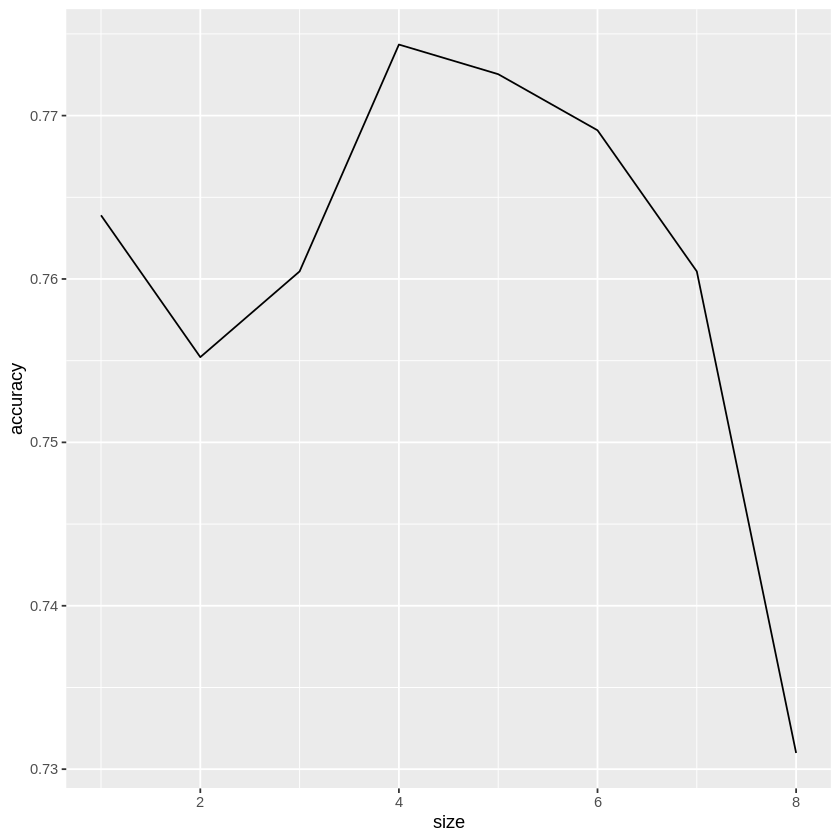

In [17]:
accuracy_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) + 
geom_line()
accuracy_plot